In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# the dataset
proj1_df=pd.read_csv('http://www.stat.uchicago.edu/~nicolae/118/PFI_2019.csv')
print(proj1_df.shape)
proj1_df.head(5)

(15500, 75)


,BASMID,ALLGRADEX,EDCPUB,SCCHOICE,SPUBCHOIX,SCONSIDR,SCHLHRSWK,EINTNET,MOSTIMPT,INTNUM,...,SEFUTUREX,DSBLTY,HHPARN19X,HHPARN19_BRD,NUMSIBSX,PARGRADEX,RACEETH,INTACC,CENREG,ZIPLOCL
0,20191000012,12,1,2,3,2,4,4,-1,-1,...,6,2,1,1,1,3,4,1,4,11
1,20191000029,4,1,2,3,2,4,3,-1,2,...,6,2,2,2,1,3,3,1,4,12
2,20191000059,11,2,2,2,1,4,3,2,2,...,5,2,2,2,1,5,2,3,2,11
3,20191000070,6,1,1,1,1,4,4,-1,-1,...,6,2,2,2,1,2,3,1,2,31
4,20191000078,9,1,2,3,2,4,4,-1,-1,...,6,2,1,1,1,5,5,1,2,21


### Note on the Data

The dataset has been curated (for example, the rows for home-schooled children were removed).

In [3]:
# test if any columns are missing responses
np.count_nonzero(proj1_df.isnull().sum())

0

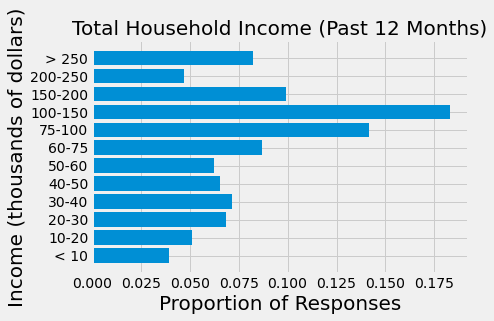

In [4]:
# graph of household incomes
income = proj1_df['TTLHHINC'].value_counts()
income.sort_index(inplace=True)
indexes = ['< 10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-75', '75-100', '100-150', '150-200', '200-250', '> 250']
income.index = indexes

plt.barh(income.index, income.values/income.sum())
font = {'family':'Times New Roman'}
plt.rc('font', **font)
plt.xlabel('Proportion of Responses', fontsize=20)
plt.ylabel('Income (thousands of dollars)', fontsize=20)
plt.title('Total Household Income (Past 12 Months)', fontsize=20);

In [8]:
# calculate proportion of families within three income ranges (< $40K, $40K-$100K, and > $100)
high = income[['100-150', '150-200', '200-250', '> 250']]
mid = income[['40-50', '50-60', '60-75', '75-100']]
low = income[['< 10', '10-20', '20-30', '30-40']]

high_prop = round(high.sum() / income.sum(), 2)
mid_prop = round(mid.sum() / income.sum(), 2)
low_prop = round(low.sum() / income.sum(), 2)

print("< $40K: \t", high_prop)
print("$40K-$100K: \t", mid_prop)
print("> $100K: \t", low_prop)

< $40K: 	 0.41
$40K-$100K: 	 0.36
> $100K: 	 0.23


In [9]:
# construct dataframe with 2019 poverty line cutoffs by size of household
# uses data from https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines
# /prior-hhs-poverty-guidelines-federal-register-references/2019-poverty-guidelines
# NOTE: Assumes households reside in 48 states or District of Columbia (not Alaska or Hawaii)
guidelines = [16910, 21330, 25750, 30170, 34590, 39010, 43430, 47850, 52270]
household_size = [2, 3, 4, 5, 6, 7, 8, 9, 10]

poverty_guidelines_2019 = pd.DataFrame({
    'HHTOTALXX': household_size,
    'POVGUIDE': guidelines,
    })

# Construct dataframe mapping total household income to median of range provided by variable
ttlhhinc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
medians = [5000, 15000, 25000, 35000, 45000, 55000, 67500, 82500, 125000, 175000, 225000, 250000]

income_2019 = pd.DataFrame({
    'TTLHHINC':ttlhhinc,
    'INCOME_ESTIMATE': medians
})

In [10]:
# join poverty_guidelines_2019 dataframe and full dataset
# join income_2019 dataframe and guidelines dataframe
guidelines_df = proj1_df.merge(poverty_guidelines_2019, on='HHTOTALXX', how='left')[['BASMID','TTLHHINC','HHTOTALXX','POVGUIDE']]
guidelines_df = guidelines_df.merge(income_2019, on='TTLHHINC', how='left')

guidelines_df.head()

,BASMID,TTLHHINC,HHTOTALXX,POVGUIDE,INCOME_ESTIMATE
0,20191000012,8,4,25750,82500
1,20191000029,5,9,47850,45000
2,20191000059,3,3,21330,25000
3,20191000070,2,3,21330,15000
4,20191000078,10,4,25750,175000


In [11]:
# determine estimate for which families fall below the poverty level
# NOTE: This is an estimate because household income is estimated from a range
guidelines_df['UNDER_POVLEVEL'] = guidelines_df['INCOME_ESTIMATE'] < guidelines_df['POVGUIDE']

# calculate proportion of dataset under poverty level
under_povlevel = np.count_nonzero(guidelines_df['UNDER_POVLEVEL'])
over_povlevel = np.count_nonzero(guidelines_df['UNDER_POVLEVEL']==False)
print('Estimated proportion of households under poverty level:', round(under_povlevel/len(guidelines_df), 3))

guidelines_df.head()

Estimated proportion of households under poverty level: 0.135


,BASMID,TTLHHINC,HHTOTALXX,POVGUIDE,INCOME_ESTIMATE,UNDER_POVLEVEL
0,20191000012,8,4,25750,82500,False
1,20191000029,5,9,47850,45000,True
2,20191000059,3,3,21330,25000,False
3,20191000070,2,3,21330,15000,True
4,20191000078,10,4,25750,175000,False


In [13]:
pov_level_df = proj1_df.merge(guidelines_df[['BASMID','UNDER_POVLEVEL']], on='BASMID', how='left')

# calculate the proportion of households with the parent answering unemployed or out of work
unemployed_above = pov_level_df.query('P1EMPL == 3 & UNDER_POVLEVEL == False')
unemployed = proj1_df.query('P1EMPL == 3')

print('Proportion of unemployed parents:', round(len(unemployed) / len(proj1_df), 2))
print('Proportion of unemployed parents above poverty level:', round(len(unemployed_above) / over_povlevel, 2))

Proportion of unemployed parents: 0.03
Proportion of unemployed parents above poverty level: 0.02


In [14]:
# calculate the proportion of parents answering survey if they are under the poverty level and out of work
unemployed_under = pov_level_df.query('UNDER_POVLEVEL == True & P1EMPL == 3')

print('Proportion of unemployed parents under poverty level:', round(len(unemployed_under) / under_povlevel, 2))

Proportion of unemployed parents under poverty level: 0.09


In [15]:
# calculate the proportion of single-parent households
single_above = pov_level_df.query('P2GUARD == 2 & UNDER_POVLEVEL == False')
single = proj1_df.query('P2GUARD == 2')

print('Proportion of single parents:', round(len(single) / len(proj1_df), 2))
print('Proportion of parents single and above FPL:', round(len(single_above) / over_povlevel, 2))

Proportion of single parents: 0.26
Proportion of parents single and above FPL: 0.22


In [16]:
# calculate the proportion of single-parent households below the poverty line
single_under = pov_level_df.query('UNDER_POVLEVEL == True & P2GUARD == 2')
single = pov_level_df.query('P2GUARD == 2')

print('Proportion of single parent households under poverty level:', round(len(single_under) / under_povlevel, 2))

Proportion of single parent households under poverty level: 0.56


In [17]:
# calculate the proportion of households with non-parent guardian
non_parent_above = pov_level_df.query('UNDER_POVLEVEL == False & HHPARN19X == 4')
non_parent = proj1_df.query('HHPARN19X == 4')

print('Proportion of households with non-parent guardian:', round(len(non_parent)/len(proj1_df), 2))
print('Proportion of households with non-parent guardian above poverty level:', round(len(non_parent_above) / over_povlevel, 2))

Proportion of households with non-parent guardian: 0.04
Proportion of households with non-parent guardian above poverty level: 0.03


In [18]:
# calculate proportion of households with non-parent guardian living below FPL
non_parent_under = pov_level_df.query('UNDER_POVLEVEL == True and HHPARN19X == 4')
print('Proportion of households with non-parent guardian under poverty level:', round(len(non_parent_under) / under_povlevel, 2))

Proportion of households with non-parent guardian under poverty level: 0.09


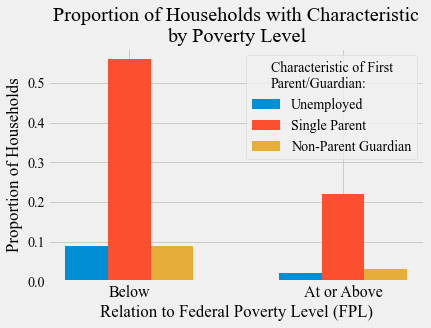

In [19]:
# graph households above and below the poverty line
# with proportions of unemployment, single parent, and non-parent guardian
unemployed = [0.09, 0.02]
single_parent = [0.56, 0.22]
non_parent = [0.09, 0.03]

x = np.arange(1, 3, 1)
width = 0.2

plt.bar(x-width, unemployed, width, label='Unemployed')
plt.bar(x, single_parent, width, label='Single Parent')
plt.bar(x+width, non_parent, width, label='Non-Parent Guardian')
plt.legend(bbox_to_anchor=(1,1), title='Characteristic of First\nParent/Guardian:')

font = {'family':'Times New Roman'}
plt.rc('font', **font)

plt.xticks(x, ['Below', 'At or Above'], fontsize=16)
plt.title('Proportion of Households with Characteristic\nby Poverty Level')
plt.xlabel('Relation to Federal Poverty Level (FPL)')
plt.ylabel('Proportion of Households');

In [20]:
unemployed = [0.09, 0.02]
single_parent = [0.56, 0.22]
non_parent = [0.09, 0.03]

pd.DataFrame({
    'Below FPL':[unemployed[0], single_parent[0], non_parent[0]],
    'Above FPL':[unemployed[1], single_parent[1], non_parent[1]]},
    index = ['Unemployment Rate', 'Single Parent Rate', 'Non-Parent Guardian Rate']
)

,Below FPL,Above FPL
Unemployment Rate,0.09,0.02
Single Parent Rate,0.56,0.22
Non-Parent Guardian Rate,0.09,0.03


In [21]:
# compare income and unemployment

# find unemployment rate for income <$40K
less_than_40 = len(proj1_df.query('1 <= TTLHHINC <= 4'))
unemploy_less_40 = len(proj1_df.query('1 <= TTLHHINC <= 4 & P1EMPL == 3'))

print('Unemployment rate for income <$40K:                 ', round(unemploy_less_40/less_than_40, 3))

# find unemployment rate for income between $40K and $100K
between_40_100 = len(proj1_df.query('5 <= TTLHHINC <= 8'))
unemploy_40_100 = len(proj1_df.query('5 <= TTLHHINC <= 8 & P1EMPL == 3'))

print('Unemployment rate for income between $40K and $100K:', round(unemploy_40_100/between_40_100, 3))

# find unemployment rate for income $100K+
more_than_100 = len(proj1_df.query('9 <= TTLHHINC <= 12'))
unemploy_100_more = len(proj1_df.query('9 <= TTLHHINC <= 12 & P1EMPL == 3'))

print('Unemployment rate for income $100K+:                ', round(unemploy_100_more/more_than_100, 3))

Unemployment rate for income <$40K:                  0.072
Unemployment rate for income between $40K and $100K: 0.025
Unemployment rate for income $100K+:                 0.01


In [22]:
# compare income and public/private school

# find public school rate for income <$40K
less_than_40 = len(proj1_df.query('1 <= TTLHHINC <= 4'))
pub_less_40 = len(proj1_df.query('1 <= TTLHHINC <= 4 & EDCPUB == 1'))

print('Public school rate for income <$40K:                 ', round(pub_less_40/less_than_40, 3))

# find public school rate for income between $40K and $100K
between_40_100 = len(proj1_df.query('5 <= TTLHHINC <= 8'))
pub_40_100 = len(proj1_df.query('5 <= TTLHHINC <= 8 & EDCPUB == 1'))

print('Public school rate for income between $40K and $100K:', round(pub_40_100/between_40_100, 3))

# find public school rate for income $100K+
more_than_100 = len(proj1_df.query('9 <= TTLHHINC <= 12'))
pub_100_more = len(proj1_df.query('9 <= TTLHHINC <= 12 & EDCPUB == 1'))

print('Public school rate for income $100K+:                ', round(pub_100_more/more_than_100, 3))

Public school rate for income <$40K:                  0.935
Public school rate for income between $40K and $100K: 0.915
Public school rate for income $100K+:                 0.841


In [23]:
# unemployment and grades pivot table
employ_grade_pivot = pd.pivot_table(proj1_df[['SEGRADES','P1EMPL']], index=['SEGRADES'], columns=['P1EMPL'], aggfunc=np.size, fill_value=0)
employ_grade_pivot

P1EMPL,1,2,3,4,5,6,7
SEGRADES,,,,,,,
-1,2,0,0,0,0,2,0
1,11134,1610,394,106,1302,346,346
2,6064,844,296,72,782,296,390
3,1768,192,100,12,214,126,176
4,324,28,30,0,44,22,48
5,2780,336,106,40,498,76,94


In [24]:
# compare unemployment and grades

# proportions for unemployed parent
unemployed_total = employ_grade_pivot[3][1:5].sum()

unemployed_a = round(employ_grade_pivot[3][1] / unemployed_total, 2)
unemployed_b = round(employ_grade_pivot[3][2] / unemployed_total, 2)
unemployed_c = round(employ_grade_pivot[3][3] / unemployed_total, 2)
unemployed_d = round(employ_grade_pivot[3][4] / unemployed_total, 2)

# proportions for employed or self-employed parent
employed_total = employ_grade_pivot[1][1:5].sum()+employ_grade_pivot[2][1:5].sum()

employed_a = round((employ_grade_pivot[1][1]+employ_grade_pivot[2][1]) / employed_total, 2)
employed_b = round((employ_grade_pivot[1][2]+employ_grade_pivot[2][2]) / employed_total, 2)
employed_c = round((employ_grade_pivot[1][3]+employ_grade_pivot[2][3]) / employed_total, 2)
employed_d = round((employ_grade_pivot[1][4]+employ_grade_pivot[2][4]) / employed_total, 2)

employ_grades = pd.DataFrame({
    'Unemployed':[unemployed_a, unemployed_b, unemployed_c, unemployed_d],
    'Employed/Self-Employed':[employed_a, employed_b, employed_c, employed_d]},
    index=["Mostly A's", "Mostly B's", "Mostly C's", "Mostly D's"]
    )

employ_grades

,Unemployed,Employed/Self-Employed
Mostly A's,0.48,0.58
Mostly B's,0.36,0.31
Mostly C's,0.12,0.09
Mostly D's,0.04,0.02


In [25]:
# single parent and grades pivot table
single_grade_pivot = pd.pivot_table(proj1_df[['SEGRADES','P2GUARD']], index=['SEGRADES'], columns=['P2GUARD'], aggfunc=np.size, fill_value=0)
single_grade_pivot

P2GUARD,1,2
SEGRADES,,
-1,2,2
1,12062,3176
2,5976,2768
3,1558,1030
4,260,236
5,3014,916


In [26]:
# compare household single parent and grades

# proportions for single parent
single_total = single_grade_pivot[2][1:5].sum()

single_a = round(single_grade_pivot[2][1] / single_total, 2)
single_b = round(single_grade_pivot[2][2] / single_total, 2)
single_c = round(single_grade_pivot[2][3] / single_total, 2)
single_d = round(single_grade_pivot[2][4] / single_total, 2)

# proportions for non-single parent
not_single_total = single_grade_pivot[1][1:5].sum()

not_single_a = round(single_grade_pivot[1][1] / not_single_total, 2)
not_single_b = round(single_grade_pivot[1][2] / not_single_total, 2)
not_single_c = round(single_grade_pivot[1][3] / not_single_total, 2)
not_single_d = round(single_grade_pivot[1][4] / not_single_total, 2)

single_grades = pd.DataFrame({
    'Single':[single_a, single_b, single_c, single_d],
    'Not Single':[not_single_a, not_single_b, not_single_c, not_single_d]},
    index=["Mostly A's", "Mostly B's", "Mostly C's", "Mostly D's"]
    )

single_grades

,Single,Not Single
Mostly A's,0.44,0.61
Mostly B's,0.38,0.30
Mostly C's,0.14,0.08
Mostly D's,0.03,0.01


In [27]:
# non-parent guardian and grades pivot table
non_parent_grade_pivot = pd.pivot_table(proj1_df[['SEGRADES','HHPARN19X']], index=['SEGRADES'], columns=['HHPARN19X'], aggfunc=np.size, fill_value=0)
non_parent_grade_pivot

HHPARN19X,1,2,3,4
SEGRADES,,,,
-1,0,0,0,4
1,11590,2452,804,392
2,5478,2192,608,466
3,1344,770,232,242
4,220,176,46,54
5,2874,750,180,126


In [28]:
# compare household non-parent guardian and grades

# proportions for non-parent guardian
non_parent_total = non_parent_grade_pivot[4][1:5].sum()

non_parent_a = round(non_parent_grade_pivot[4][1] / non_parent_total, 2)
non_parent_b = round(non_parent_grade_pivot[4][2] / non_parent_total, 2)
non_parent_c = round(non_parent_grade_pivot[4][3] / non_parent_total, 2)
non_parent_d = round(non_parent_grade_pivot[4][4] / non_parent_total, 2)

# proportions for parent guardian
parent_total = non_parent_grade_pivot[1][1:5].sum()+non_parent_grade_pivot[2][1:5].sum()+non_parent_grade_pivot[3][1:5].sum()

parent_a = round((non_parent_grade_pivot[1][1]+non_parent_grade_pivot[2][1]+non_parent_grade_pivot[3][1]) / parent_total, 2)
parent_b = round((non_parent_grade_pivot[1][2]+non_parent_grade_pivot[2][2]+non_parent_grade_pivot[3][2]) / parent_total, 2)
parent_c = round((non_parent_grade_pivot[1][3]+non_parent_grade_pivot[2][3]+non_parent_grade_pivot[3][3]) / parent_total, 2)
parent_d = round((non_parent_grade_pivot[1][4]+non_parent_grade_pivot[2][4]+non_parent_grade_pivot[3][4]) / parent_total, 2)

non_parent_grades = pd.DataFrame({
    'Non-Parent Guardian':[non_parent_a, non_parent_b, non_parent_c, non_parent_d],
    'Parent Guardian':[parent_a, parent_b, parent_c, parent_d]},
    index=["Mostly A's", "Mostly B's", "Mostly C's", "Mostly D's"]
    )

non_parent_grades

,Non-Parent Guardian,Parent Guardian
Mostly A's,0.34,0.57
Mostly B's,0.40,0.32
Mostly C's,0.21,0.09
Mostly D's,0.05,0.02


In [29]:
# compare household poverty level and grades
pov_grades_df = pov_level_df[['SEGRADES','UNDER_POVLEVEL']]

underpov_total = len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 1')) +\
                 len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 2')) +\
                 len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 3')) +\
                 len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 4'))

underpov_a = round(len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 1')) / underpov_total, 2)
underpov_b = round(len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 2')) / underpov_total, 2)
underpov_c = round(len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 3')) / underpov_total, 2)
underpov_d = round(len(pov_grades_df.query('UNDER_POVLEVEL == True & SEGRADES == 4')) / underpov_total, 2)

overpov_total = len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 1')) +\
                len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 2')) +\
                len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 3')) +\
                len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 4'))

overpov_a = round(len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 1')) / overpov_total, 2)
overpov_b = round(len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 2')) / overpov_total, 2)
overpov_c = round(len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 3')) / overpov_total, 2)
overpov_d = round(len(pov_grades_df.query('UNDER_POVLEVEL == False & SEGRADES == 4')) / overpov_total, 2)

povlvl_grades_df = pd.DataFrame({
    'Under FPL': [underpov_a, underpov_b, underpov_c, underpov_d],
    'At or Over FPL': [overpov_a, overpov_b, overpov_c, overpov_d]},
    index=["Mostly A's", "Mostly B's", "Mostly C's", "Mostly D's"]
    )
povlvl_grades_df

,Under FPL,At or Over FPL
Mostly A's,0.38,0.59
Mostly B's,0.42,0.31
Mostly C's,0.16,0.09
Mostly D's,0.04,0.01


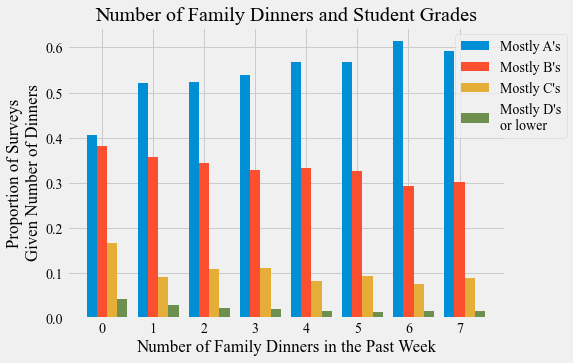

In [30]:
# number of family dinners and student grades
meal_grade_pivot = pd.pivot_table(proj1_df[['SEGRADES','FODINNERX']], index=['SEGRADES'], columns=['FODINNERX'], aggfunc=np.size, fill_value=0)

# exclude number of students who do not have letter grades from totals
totals = [meal_grade_pivot[0].sum()-meal_grade_pivot[0][5], meal_grade_pivot[1].sum()-meal_grade_pivot[1][5], 
          meal_grade_pivot[2].sum()-meal_grade_pivot[2][5], meal_grade_pivot[3].sum()-meal_grade_pivot[3][5],
          meal_grade_pivot[4].sum()-meal_grade_pivot[4][5], meal_grade_pivot[5].sum()-meal_grade_pivot[5][5], 
          meal_grade_pivot[6].sum()-meal_grade_pivot[6][5], meal_grade_pivot[7].sum()-meal_grade_pivot[7][5]]

meal_a = meal_grade_pivot.loc[1] / totals
meal_b = meal_grade_pivot.loc[2] / totals
meal_c = meal_grade_pivot.loc[3] / totals
meal_d = meal_grade_pivot.loc[4] / totals

x = np.arange(8)
width = 0.2

plt.figure(figsize=(7,5))

plt.bar(x-width, meal_a, width, label="Mostly A's")
plt.bar(x, meal_b, width, label="Mostly B's")
plt.bar(x+width, meal_c, width, label="Mostly C's")
plt.bar(x+2*width, meal_d, width, label="Mostly D's\nor lower")
plt.legend(bbox_to_anchor=(0.87,1))

plt.ylabel('Proportion of Surveys\nGiven Number of Dinners')
plt.xlabel('Number of Family Dinners in the Past Week')
plt.title('Number of Family Dinners and Student Grades');

In [31]:
# compare parent attendance of events and student grades

# find rate of grades for parents attending events
attend_a = len(proj1_df.query('FSSPORTX == 1 & SEGRADES == 1'))
attend_b = len(proj1_df.query('FSSPORTX == 1 & SEGRADES == 2'))
attend_c = len(proj1_df.query('FSSPORTX == 1 & SEGRADES == 3'))
attend_d = len(proj1_df.query('FSSPORTX == 1 & SEGRADES == 4'))
attend = attend_a + attend_b + attend_c + attend_d

print('Rate of A grades for students whose parents attend school events:       ', round(attend_a/attend, 3))
print('Rate of B grades for students whose parents attend school events:       ', round(attend_b/attend, 3))
print('Rate of C grades for students whose parents attend school events:       ', round(attend_c/attend, 3))
print('Rate of D grades for students whose parents attend school events:       ', round(attend_d/attend, 3))

# find rate of grades for parents not attending events
not_attend_a = len(proj1_df.query('FSSPORTX == 2 & SEGRADES == 1'))
not_attend_b = len(proj1_df.query('FSSPORTX == 2 & SEGRADES == 2'))
not_attend_c = len(proj1_df.query('FSSPORTX == 2 & SEGRADES == 3'))
not_attend_d = len(proj1_df.query('FSSPORTX == 2 & SEGRADES == 4'))
not_attend = not_attend_a + not_attend_b + not_attend_c + not_attend_d

print('Rate of A grades for students whose parents do not attend school events:', round(not_attend_a/not_attend, 3))
print('Rate of B grades for students whose parents do not attend school events:', round(not_attend_b/not_attend, 3))
print('Rate of C grades for students whose parents do not attend school events:', round(not_attend_c/not_attend, 3))
print('Rate of D grades for students whose parents do not attend school events:', round(not_attend_d/not_attend, 3))

Rate of A grades for students whose parents attend school events:        0.602
Rate of B grades for students whose parents attend school events:        0.309
Rate of C grades for students whose parents attend school events:        0.077
Rate of D grades for students whose parents attend school events:        0.012
Rate of A grades for students whose parents do not attend school events: 0.421
Rate of B grades for students whose parents do not attend school events: 0.371
Rate of C grades for students whose parents do not attend school events: 0.165
Rate of D grades for students whose parents do not attend school events: 0.043


In [32]:
# pivot table for parent attendance of events and student enjoyment of school
ae_enjoy_pivot = pd.pivot_table(proj1_df[['SEENJOY','FSSPORTX']], index=['SEENJOY'], columns=['FSSPORTX'], aggfunc=np.size, fill_value=0)
ae_enjoy_pivot

FSSPORTX,-1,1,2
SEENJOY,,,
-1,4,0,0
1,74,9736,1640
2,138,12430,3448
3,24,1938,888
4,12,418,250


In [33]:
# calculate relative proportion of agree vs disagree for parent attendance of events and student enjoyment
attend_agree = ae_enjoy_pivot[1][1:3].sum()
attend_disagree = ae_enjoy_pivot[1][3:5].sum()

not_attend_agree = ae_enjoy_pivot[2][1:3].sum()
not_attend_disagree = ae_enjoy_pivot[2][3:5].sum()

attend = ae_enjoy_pivot[1].sum()
not_attend = ae_enjoy_pivot[2].sum()

prop_attend_agree = round(attend_agree / attend, 3)
prop_attend_disagree = round(attend_disagree / attend, 3)
prop_not_attend_agree = round(not_attend_agree / not_attend, 3)
prop_not_attend_disagree = round(not_attend_disagree / not_attend, 3)

print('Proportion of students with parents attending events who enjoy school:           ',prop_attend_agree)
print('Proportion of students with parents attending events who do not enjoy school:    ',prop_attend_disagree)
print('Proportion of students with parents not attending events who enjoy school:       ',prop_not_attend_agree)
print('Proportion of students with parents not attending events who do not enjoy school:',prop_not_attend_disagree)

Proportion of students with parents attending events who enjoy school:            0.904
Proportion of students with parents attending events who do not enjoy school:     0.096
Proportion of students with parents not attending events who enjoy school:        0.817
Proportion of students with parents not attending events who do not enjoy school: 0.183


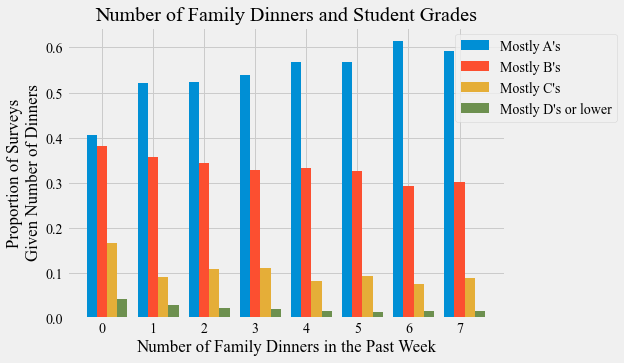

In [34]:
# number of family dinners and student grades
meal_grade_pivot = pd.pivot_table(proj1_df[['SEGRADES','FODINNERX']], index=['SEGRADES'], columns=['FODINNERX'], aggfunc=np.size, fill_value=0)

# exclude number of students who do not have letter grades from totals
totals = [meal_grade_pivot[0].sum()-meal_grade_pivot[0][5], meal_grade_pivot[1].sum()-meal_grade_pivot[1][5], 
          meal_grade_pivot[2].sum()-meal_grade_pivot[2][5], meal_grade_pivot[3].sum()-meal_grade_pivot[3][5],
          meal_grade_pivot[4].sum()-meal_grade_pivot[4][5], meal_grade_pivot[5].sum()-meal_grade_pivot[5][5], 
          meal_grade_pivot[6].sum()-meal_grade_pivot[6][5], meal_grade_pivot[7].sum()-meal_grade_pivot[7][5]]

meal_a = meal_grade_pivot.loc[1] / totals
meal_b = meal_grade_pivot.loc[2] / totals
meal_c = meal_grade_pivot.loc[3] / totals
meal_d = meal_grade_pivot.loc[4] / totals

x = np.arange(8)
width = 0.2

plt.figure(figsize=(7,5))

plt.bar(x-width, meal_a, width, label="Mostly A's")
plt.bar(x, meal_b, width, label="Mostly B's")
plt.bar(x+width, meal_c, width, label="Mostly C's")
plt.bar(x+2*width, meal_d, width, label="Mostly D's or lower")
plt.legend(bbox_to_anchor=(0.87,1))

plt.ylabel('Proportion of Surveys\nGiven Number of Dinners')
plt.xlabel('Number of Family Dinners in the Past Week')
plt.title('Number of Family Dinners and Student Grades');

In [35]:
# pivot table for enjoyment of school and number of family dinners
meal_enjoy_pivot = pd.pivot_table(proj1_df[['SEENJOY','FODINNERX']], index=['SEENJOY'], columns=['FODINNERX'], aggfunc=np.size, fill_value=0)
meal_enjoy_pivot

FODINNERX,0,1,2,3,4,5,6,7
SEENJOY,,,,,,,,
-1,2,0,0,0,0,0,0,2
1,302,266,626,1182,1442,2230,950,4452
2,746,548,1274,2148,2182,3362,1080,4676
3,224,158,272,400,392,540,198,666
4,78,36,62,70,66,108,44,216


FODINNERX
0    0.775148
1    0.807540
2    0.850492
3    0.876316
4    0.887800
5    0.896154
6    0.893486
7    0.911706
dtype: float64


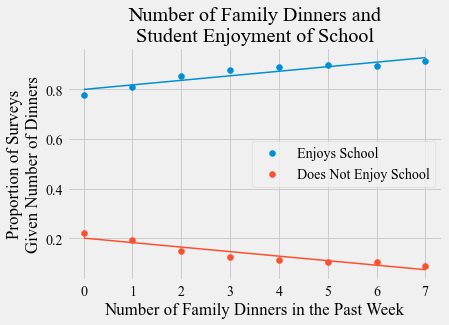

In [37]:
# graph student family dinners and student enjoyment of school
enjoy_agree = meal_enjoy_pivot.loc[1:2].sum()
enjoy_disagree = meal_enjoy_pivot.loc[3:4].sum()

meal_totals = [meal_enjoy_pivot[0].sum(), meal_enjoy_pivot[1].sum(), meal_enjoy_pivot[2].sum(), meal_enjoy_pivot[3].sum(),
               meal_enjoy_pivot[4].sum(), meal_enjoy_pivot[5].sum(), meal_enjoy_pivot[6].sum(), meal_enjoy_pivot[7].sum()]

meal_enjoy_agree = enjoy_agree / meal_totals
meal_enjoy_disagree = enjoy_disagree / meal_totals

print(meal_enjoy_agree)

#find line of best fit
a, b = np.polyfit(meal_enjoy_agree.index, meal_enjoy_agree.values, 1)
c, d = np.polyfit(meal_enjoy_disagree.index, meal_enjoy_disagree.values, 1)

plt.scatter(meal_enjoy_agree.index, meal_enjoy_agree.values, label='Enjoys School')
plt.scatter(meal_enjoy_disagree.index, meal_enjoy_disagree.values, label='Does Not Enjoy School')

plt.plot(meal_enjoy_agree.index, a*meal_enjoy_agree.index+b, linewidth=1.5)
plt.plot(meal_enjoy_disagree.index, c*meal_enjoy_disagree.index+d, linewidth=1.5)

plt.legend()
plt.xlabel('Number of Family Dinners in the Past Week')
plt.ylabel('Proportion of Surveys\nGiven Number of Dinners')
plt.title('Number of Family Dinners and\nStudent Enjoyment of School');